In [ ]:
# %load_ext memory_profiler

# Capstone V8 model

Fork: V7

same as capstoneV7 but with smaller MAX_WORD and MAX_SEQUENCE_LENGTH but with class weight.

The validation F1-score is {} at a threshold of {}.

# Constants

In [ ]:
MODEL_VERSION = 'capstoneV8'
MAX_SEQUENCE_LENGTH = 70
EMBEDDING_DIM = 300
MAX_WORDS = 40000

## Common english contraction mappings (wikipedia):
https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions

In [ ]:
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [ ]:
PUNCT = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [ ]:
SPECIAL_PUNCT = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}

In [ ]:
PUNCT_MAPPING = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [ ]:
MISPELL_MAPPING = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}

# Helpers

## Embedding helpers

In [ ]:
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import os

def loadEmbeddings(path, dimensions, mode='r', encoding=None, errors=None):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    f = open(path, buffering=((2<<16) + 8), mode=mode, encoding=encoding, errors=errors)
    for line in f:
        if len(line) <= 100:
            continue
        values = line.split()
        word = ''.join(values[:-dimensions])
        coefs = np.asarray(values[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [ ]:
def loadEmbeddingsGensim(path, dimensions, binary=True):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    gensim_vecs = KeyedVectors.load_word2vec_format(path, binary=binary)
    for word, vector in zip(gensim_vecs.vocab, gensim_vecs.vectors):
        coefs = np.asarray(vector[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [ ]:
def getEmbeddingMatrix(embedding, word_index):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    nb_words = min(MAX_WORDS, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

### Helper to replace contractions in dataset

In [ ]:
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([CONTRACTION_MAPPING[t] if t in CONTRACTION_MAPPING else t for t in text.split(" ")])
    return text

### Helper to remap punctuations in dataset

In [ ]:
def clean_special_chars(text):
    for p in PUNCT_MAPPING:
        text = text.replace(p, PUNCT_MAPPING[p])
    
    for p in PUNCT:
        text = text.replace(p, ' ' + p + ' ')
    
    for s in SPECIAL_PUNCT:
        text = text.replace(s, SPECIAL_PUNCT[s])
    
    return text

### Helper to correct common mispellings

In [ ]:
def correct_spelling(x):
    for word in MISPELL_MAPPING.keys():
        x = x.replace(word, MISPELL_MAPPING[word])
    return x

## Coverage helpers

In [ ]:
from collections import Counter

def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = Counter()
    for sentence in sentences:
        for word in sentence:
            vocab[word] += 1
    return vocab

In [ ]:
import operator

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

# Import test/train dataset

In [ ]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = -1

# Analyze train and test data

In [ ]:
print("Sample insincere questions")
train_df.loc[train_df['target'] == 1].sample(10)

In [ ]:
print("Sample sincere questions")
train_df.loc[train_df['target'] == 0].sample(10)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

target_ratios = train_df.target.value_counts(normalize=True)

print(target_ratios)

target_ratios.plot(kind='bar', title='Ratios (target)')
plt.show()

In [ ]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x.split())))))

In [ ]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x.split())))))

In [ ]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x)))))

In [ ]:
print('Max character length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x)))))
print('Max character length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x)))))

In [ ]:
print('p999 character length of questions in train is {0:.0f}.'.format(np.percentile(train_df['question_text'].apply(lambda x: len(x)), 99.9)))
print('p999 character length of questions in test is {0:.0f}.'.format(np.percentile(test_df['question_text'].apply(lambda x: len(x)), 99.9)))

# Data processing


## TODO: Feature engineering

Add feature engineering here.

In [ ]:
%%time

train_df['treated_question'] = train_df['question_text'].apply(lambda x: x.lower())
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_contractions(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_special_chars(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: correct_spelling(x))

test_df['treated_question'] = test_df['question_text'].apply(lambda x: x.lower())
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_contractions(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_special_chars(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: correct_spelling(x))

## Fill data

In [ ]:
X_train = train_df['treated_question'].fillna('+++').tolist()
y_train = train_df['target']
X_test = test_df['treated_question'].fillna('+++').tolist()


print('Found %s training questions.' % len(X_train))
print('Found %s test questions.' % len(X_test))

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, split=' ', filters='',
                       char_level=False, oov_token=None, document_count=0,
                      )
                                   
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

## Save tokenized data + word index

In [ ]:
%%time

import gc
import pickle

test_df.to_pickle('test_df.pkl')

np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
y_train.to_pickle('y_train.pkl')

pickle.dump(word_index, open('word_index.pkl', 'wb'))

del X_train
del X_test
del y_train

gc.collect()


## Build vocabulary with counts

In [ ]:
%%time

train_vocab = build_vocab(train_df['treated_question'])
del train_df
test_vocab = build_vocab(test_df['treated_question'])
del test_df

vocab = train_vocab + test_vocab
del train_vocab
del test_vocab

## Load embeddings, measure coverage and save embedding matrix

# Restore point (optional)

In [ ]:
'''
%%time

import pickle

word_index = pickle.load(open('word_index.pkl', 'rb'))
'''

In [ ]:
%%time

import gc

print('glove:')
glove_path = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
embeddings_index = loadEmbeddings(glove_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('glove.npy', embedding_matrix)

In [ ]:
print('paragram:')
paragram_path = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
embeddings_index = loadEmbeddings(paragram_path, EMBEDDING_DIM, encoding='utf8', errors='ignore')
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('paragram.npy', embedding_matrix)

In [ ]:
print('wiki:')
wiki_path = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
embeddings_index = loadEmbeddings(wiki_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('wiki.npy', embedding_matrix)

In [ ]:
print('google_news:')
google_news_path = '../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
embeddings_index = loadEmbeddingsGensim(google_news_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('google_news.npy', embedding_matrix)

In [ ]:
del word_index
del vocab
gc.collect()

# Oversample training data

In [ ]:
'''
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
'''


In [ ]:
'''
balanced_train_df = pd.DataFrame()
balanced_train_df[0] = np.array(y_train)

target_ratios = balanced_train_df[0].value_counts(normalize=True)

print(target_ratios)

target_ratios.plot(kind='bar', title='Ratios after SMOTE (target)')
'''

# Setup model

# Restore point

In [ ]:
%%time

import numpy as np
import pandas as pd
import pickle

test_df = pd.read_pickle('test_df.pkl')

X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = pd.read_pickle('y_train.pkl')


## Embeddings Layers

In [ ]:
from keras.layers import Embedding

embedding_layers = {}

embedding_matrix = np.load('glove.npy')
embedding_layers['glove'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)

embedding_matrix = np.load('paragram.npy')
embedding_layers['paragram'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)

embedding_matrix = np.load('wiki.npy')
embedding_layers['wiki'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)

embedding_matrix = np.load('google_news.npy')
embedding_layers['google_news'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)

## NN: Bidirectional GRU per embedding with concactenation

In [ ]:
%%time 

from keras.layers import Dense, Dropout, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional
from keras.layers import Activation, BatchNormalization, CuDNNGRU
from keras.layers import SpatialDropout1D, Concatenate, Flatten, Reshape
from keras.regularizers import l2
from keras.models import Model


inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

a = embedding_layers['glove'] (inp)
a = Bidirectional(CuDNNGRU(64, return_sequences=True))(a)
a = BatchNormalization()(a)
a = GlobalMaxPool1D()(a)
a = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(a)
a = BatchNormalization()(a)
a = Activation("relu")(a)
a = Dropout(0.1)(a)

b = embedding_layers['paragram'] (inp)
b = Bidirectional(CuDNNGRU(64, return_sequences=True))(b)
b = BatchNormalization()(b)
b = GlobalMaxPool1D()(b)
b = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(b)
b = BatchNormalization()(b)
b = Activation("relu")(b)
b = Dropout(0.1)(b)

c = embedding_layers['wiki'] (inp)
c = Bidirectional(CuDNNGRU(64, return_sequences=True))(c)
c = BatchNormalization()(c)
c = GlobalMaxPool1D()(c)
c = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Dropout(0.1)(c)

d = embedding_layers['google_news'] (inp)
d = Bidirectional(CuDNNGRU(64, return_sequences=True))(d)
d = BatchNormalization()(d)
d = GlobalMaxPool1D()(d)
d = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(d)
d = BatchNormalization()(d)
d = Activation("relu")(d)
d = Dropout(0.1)(d)

x = Concatenate(axis=1)([a, b, c, d])
x = Dense(32, kernel_regularizer=l2(0.01), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dense(1, use_bias=False)(x)
x = BatchNormalization()(x)
out = Activation("sigmoid")(x)

model = Model(inp, out)

print(model.summary())

In [ ]:
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

# Compile the model

In [ ]:


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1, recall, precision])

# serialize model

In [ ]:
model.save('model.h5')
print("Saved model to disk")

# Setup f1-score, precision and recall metrics

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoints = ModelCheckpoint(MODEL_VERSION + '.weights_checkpoint.h5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)

In [ ]:
'''
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support

class Metrics(Callback):


    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_precision, _val_recall, _val_f1, _ = precision_recall_fscore_support(val_targ, val_predict, average='binary')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" %(_val_f1, _val_precision, _val_recall))
        return

metrics = Metrics()
'''

# Compute Class Weights

Since there is a significant target inbalance.

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

print (class_weights)

## Split train/validation

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8,
                                              random_state=233)

# Train the model

Use model checkpointing to save the model that attains the best validation loss.

In [ ]:
%%time


hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], class_weight=class_weights, epochs=2, batch_size=256)


# Predict validation labels

In [ ]:
%%time

pred_val = model.predict([X_val], batch_size=1024, verbose=1)

# Find optimal threshold

In [61]:
from sklearn.metrics import f1_score, precision_score, recall_score

def optimalThreshold(y_true,y_pred):
    idx = 0
    cur_f1 = 0
    cur_prec = 0
    cur_recall = 0
    max_f1 = 0
    thres = 0
    for idx in np.arange(0.1, 0.501, 0.01):
        cur_f1 = f1_score(y_true, np.array(y_pred)> idx)
        cur_recall = recall_score(y_true, np.array(y_pred)> idx)
        cur_prec = precision_score(y_true, np.array(y_pred)> idx)
        print('Current threshold is {:.4f} with F1 score: {:.4f}, Recall score: {:.4f}, Precision score: {:.4f}'
              .format(idx, cur_f1, cur_recall, cur_prec)
             )
        if cur_f1 > max_f1:
            max_f1 = cur_f1
            thres = idx
    print('optimal threshold is {:.4f} with F1 score: {:.4f}'.format(thres, max_f1))
    return thres
threshold = optimalThreshold(y_val,pred_val)

Current threshold is 0.1000 with F1 score: 0.5943, Recall score: 0.8865, Precision score: 0.4470
Current threshold is 0.1100 with F1 score: 0.6063, Recall score: 0.8789, Precision score: 0.4628
Current threshold is 0.1200 with F1 score: 0.6159, Recall score: 0.8716, Precision score: 0.4762
Current threshold is 0.1300 with F1 score: 0.6247, Recall score: 0.8627, Precision score: 0.4897
Current threshold is 0.1400 with F1 score: 0.6318, Recall score: 0.8540, Precision score: 0.5013
Current threshold is 0.1500 with F1 score: 0.6382, Recall score: 0.8465, Precision score: 0.5121
Current threshold is 0.1600 with F1 score: 0.6443, Recall score: 0.8387, Precision score: 0.5230
Current threshold is 0.1700 with F1 score: 0.6476, Recall score: 0.8284, Precision score: 0.5316
Current threshold is 0.1800 with F1 score: 0.6523, Recall score: 0.8216, Precision score: 0.5408
Current threshold is 0.1900 with F1 score: 0.6566, Recall score: 0.8150, Precision score: 0.5498
Current threshold is 0.2000 wi

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, np.array(pred_val > threshold).astype(int), target_names=['sincere', 'insincere']))


             precision    recall  f1-score   support

    sincere       0.98      0.97      0.98    245044
  insincere       0.62      0.74      0.67     16181

avg / total       0.96      0.96      0.96    261225



[Text(0, 0.5, 'sincere'), Text(0, 1.5, 'insincere')]

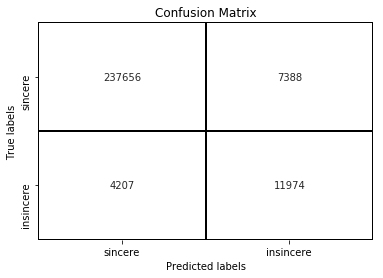

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = confusion_matrix(y_val, np.array(pred_val > threshold).astype(int))
ax = plt.subplot()
hm = sns.heatmap(cm, annot=True, ax = ax, fmt='g', 
                 cmap=ListedColormap(['white']), linecolor='black', 
                 linewidth=1, cbar=False,
                 xticklabels = 1, yticklabels = 1 )


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['sincere', 'insincere'])
ax.yaxis.set_ticklabels(['sincere', 'insincere'])



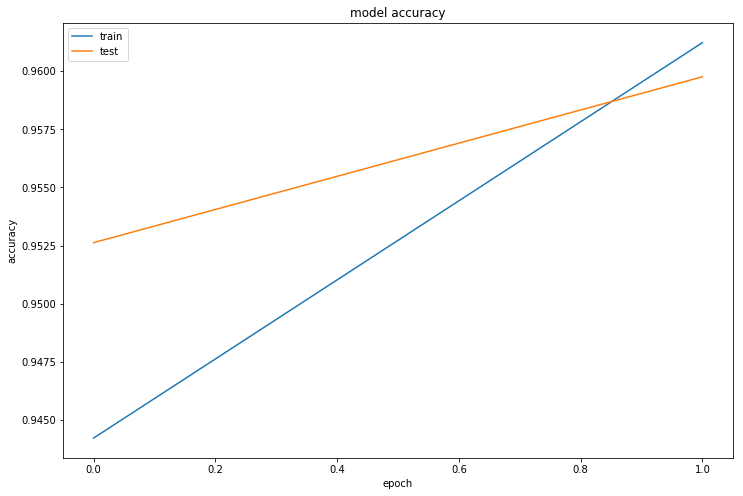

In [64]:
plt.figure(figsize=(12,8))
plt.title('model accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

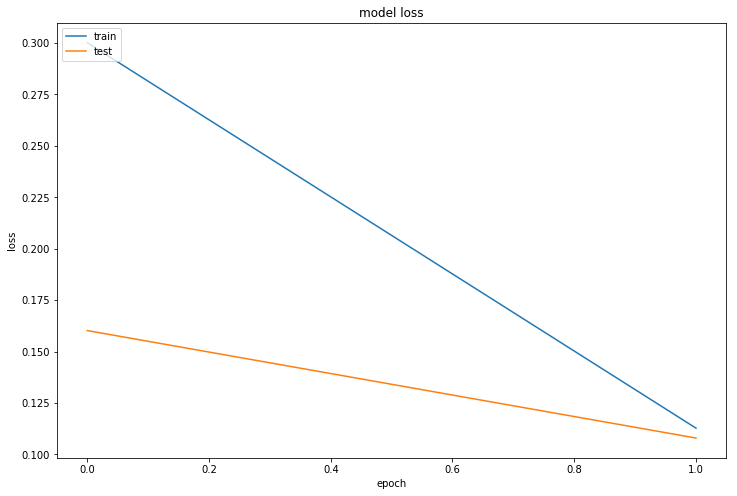

In [65]:
plt.figure(figsize=(12,8))
plt.title('model loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

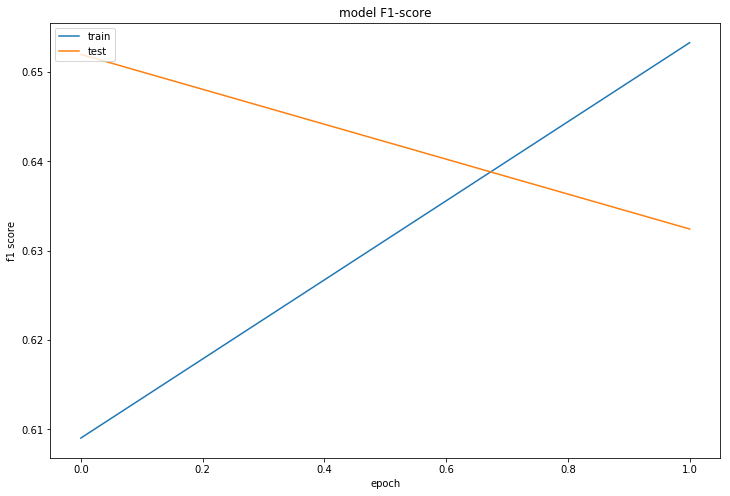

In [66]:
plt.figure(figsize=(12,8))
plt.title('model F1-score')
plt.plot(hist.history['f1'])
plt.plot(hist.history['val_f1'])
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# serialize weights

In [67]:
model.save_weights(MODEL_VERSION + '.weights.h5')
print("Saved model weights to disk")

Saved model weights to disk


# Predict test labels

In [68]:
%%time

pred_test = model.predict([X_test], batch_size=1024, verbose=1)

56370/56370 [==============================] - 2s 36us/step
CPU times: user 2 s, sys: 356 ms, total: 2.35 s
Wall time: 2.05 s


# Prepare submission

In [69]:
submission_df = pd.DataFrame({"qid":test_df["qid"].values})
submission_df['prediction'] = (pred_test > threshold).astype(int)
submission_df.to_csv("submission.csv", index=False)

In [70]:
type(hist)

keras.callbacks.History

In [71]:
import pickle


pickle_out = open(MODEL_VERSION + '.hist.pkl',"wb")
pickle.dump(hist, pickle_out)
pickle_out.close()